In [421]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [422]:
raw = pd.read_csv('tr_eikon_eod_data.csv', 
                 index_col = 0, parse_dates = True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [423]:
colnames = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [424]:
data = raw[colnames].dropna()

rets = pd.DataFrame()

for stock in colnames:
    data[f"{stock} ret"] = np.log(data[stock] / data[stock].shift(1))

data.dropna(inplace=True)    

for stock in colnames:
    data[f"{stock} dir"] = np.sign(data[f"{stock} ret"]).astype(int)

In [425]:
stock_bins = {}

for stock in colnames:
    mean = data[f'{stock} ret'].mean()
    std = data[f'{stock } ret'].std()
    stock_bins[stock] = [mean - std, mean, mean + std]

features = [] # creating an empty list for storing column names
for stock in colnames:
    for i in range(1,6):
        feat = f'{stock} lag_' + str(i)
        data[feat] = np.digitize(data[f'{stock} ret'].shift(i), stock_bins[stock])
        features.append(feat)

data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,AAPL.O ret,MSFT.O ret,INTC.O ret,AMZN.O ret,GS.N ret,...,AMZN.O lag_1,AMZN.O lag_2,AMZN.O lag_3,AMZN.O lag_4,AMZN.O lag_5,GS.N lag_1,GS.N lag_2,GS.N lag_3,GS.N lag_4,GS.N lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,30.625684,30.960,20.87,134.690,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525,...,3,3,3,3,3,3,3,3,3,3
2010-01-06,30.138541,30.770,20.80,132.250,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,...,2,3,3,3,3,3,3,3,3,3
2010-01-07,30.082827,30.452,20.60,130.000,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,...,0,2,3,3,3,1,3,3,3,3
2010-01-08,30.282827,30.660,20.83,133.520,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093,...,1,0,2,3,3,3,1,3,3,3
2010-01-11,30.015684,30.270,20.95,130.308,171.56,-0.008861,-0.012802,0.005744,-0.024350,-0.015902,...,3,1,0,2,3,0,3,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.150,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,...,1,1,2,2,2,1,1,1,1,1
2018-06-26,184.430000,99.080,49.67,1691.090,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,...,0,1,1,2,2,0,1,1,1,1
2018-06-27,184.160000,97.540,48.76,1660.510,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,...,2,0,1,1,2,2,0,1,1,1


In [426]:
def calculate_rsi(prices, period=14):
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)
    
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_bins = {}

for stock in colnames:
    feat = f"{stock} rsi"
    data[feat] = calculate_rsi(data[stock])
    mean = data[feat].mean()
    std = data[feat].std()
    rsi_bins[stock] = [mean - std, mean, mean + std]
    
    data[feat] = data[feat].shift(1)

In [427]:
def moving_average(data, window_short=20, window_long=60):
    """
    Calculate short-term and long-term moving averages.

    Parameters:
    - data: List or array-like object containing the time series data.
    - window_short: Integer specifying the window size for the short-term moving average.
    - window_long: Integer specifying the window size for the long-term moving average.

    Returns:
    - short_ma: List containing the short-term moving averages.
    - long_ma: List containing the long-term moving averages.
    """

    # Calculate short-term moving average
    short_ma = data.rolling(window=window_short).mean()

    # Calculate long-term moving average
    long_ma = data.rolling(window=window_long).mean()

    return short_ma, long_ma

for stock in colnames:
    short, long = moving_average(data[f"{stock} ret"])
    data[f'{stock} SMA'] = np.where(short > long, 1, -1)
    data[f"{stock} SMA"].shift(1)

features += [f"{stock} SMA" for stock in colnames]


In [428]:
feat_data = data.dropna()

for stock in colnames:
    feat = f"{stock} digi-rsi"
    rsi = f"{stock} rsi"
    feat_data[feat] = np.digitize(feat_data[rsi], [30, 70])

feat_data[features]

C:\Users\chaos\AppData\Local\Temp\ipykernel_13276\2113226934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_data[feat] = np.digitize(feat_data[rsi], [30, 70])
C:\Users\chaos\AppData\Local\Temp\ipykernel_13276\2113226934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_data[feat] = np.digitize(feat_data[rsi], [30, 70])
C:\Users\chaos\AppData\Local\Temp\ipykernel_13276\2113226934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,AAPL.O lag_1,AAPL.O lag_2,AAPL.O lag_3,AAPL.O lag_4,AAPL.O lag_5,MSFT.O lag_1,MSFT.O lag_2,MSFT.O lag_3,MSFT.O lag_4,MSFT.O lag_5,...,GS.N lag_1,GS.N lag_2,GS.N lag_3,GS.N lag_4,GS.N lag_5,AAPL.O SMA,MSFT.O SMA,INTC.O SMA,AMZN.O SMA,GS.N SMA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-26,3,0,0,0,3,2,0,0,0,2,...,2,0,0,2,2,-1,-1,-1,-1,-1
2010-01-27,2,3,0,0,0,2,2,0,0,0,...,0,2,0,0,2,-1,-1,-1,-1,-1
2010-01-28,2,2,3,0,0,2,2,2,0,0,...,2,0,2,0,0,-1,-1,-1,-1,-1
2010-01-29,0,2,2,3,0,0,2,2,2,0,...,2,2,0,2,0,-1,-1,-1,-1,-1
2010-02-01,0,0,2,2,3,0,0,2,2,2,...,0,2,2,0,2,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,1,1,2,0,1,1,1,2,1,2,...,1,1,1,1,1,-1,-1,-1,-1,-1
2018-06-26,1,1,1,2,0,0,1,1,2,1,...,0,1,1,1,1,-1,-1,-1,-1,1
2018-06-27,2,1,1,1,2,2,0,1,1,2,...,2,0,1,1,1,-1,-1,-1,-1,1


In [429]:
def print_data(string, data):
    print("-" * 100)
    print(string)
    print("-" * 100)
    print(data)

----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.575807
MSFT.O ret    1.710198
INTC.O ret    1.316821
AMZN.O ret    2.078885
GS.N ret      1.277704
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.782198
MSFT.O ret    1.321179
INTC.O ret    1.737787
AMZN.O ret    2.885781
GS.N ret      1.397988
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    184
MSFT.O dir    207
INTC.O dir    186
AMZN.O dir    182
GS.N dir    

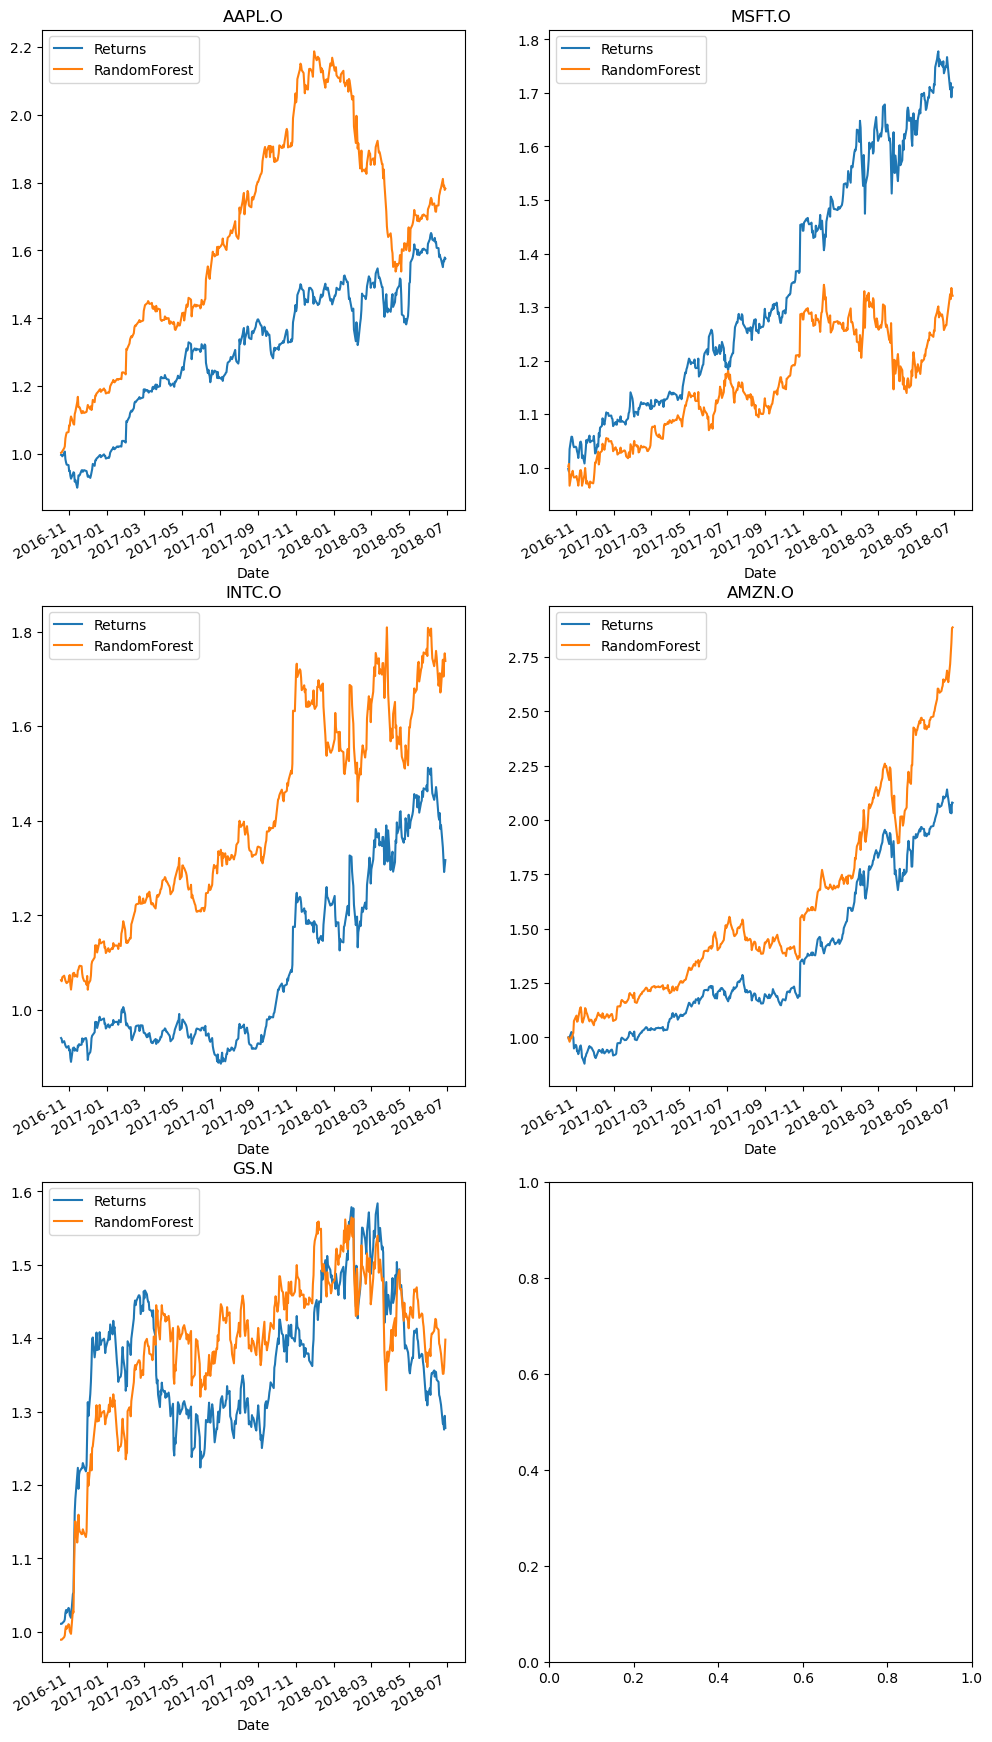

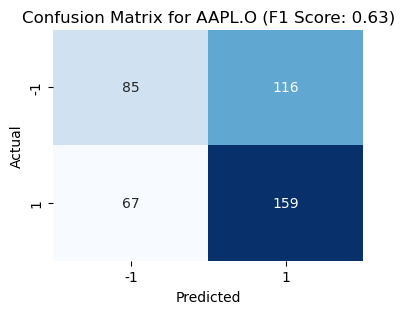

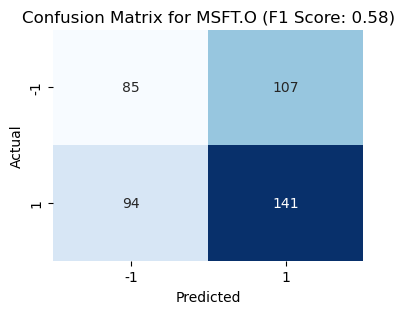

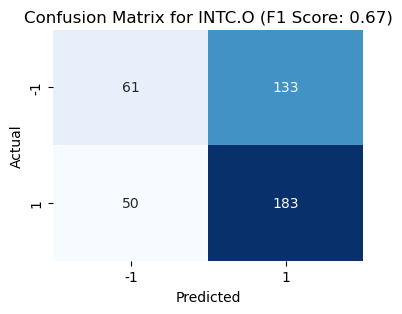

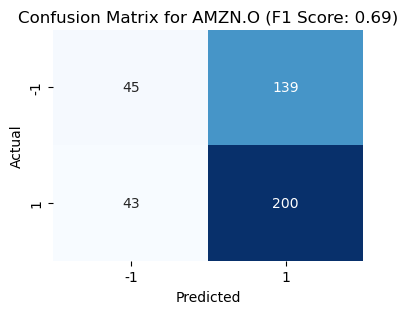

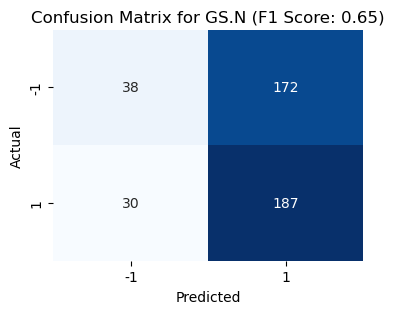

[[-1 -1 -1 -1 -1]
 [-1 -1  1  1  1]
 [-1 -1 -1 -1  1]
 ...
 [-1 -1 -1 -1 -1]
 [-1 -1  1  1  1]
 [-1 -1 -1 -1 -1]]


In [430]:
# data_train, data_test = train_test_split(feat_data, 
#                                          test_size = 0.2,
#                                          random_state = 0)

test_split = len(data) // 5

data_train = feat_data[:- test_split]
data_test = feat_data[-test_split:]

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

model.fit(training, training_res)

results = model.predict(testing)

print_data("Returns:", data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print_data("RandomForest returns:", (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))

print_data("False predictions:", (results != data_test[[f"{stock} dir" for stock in colnames]]).sum())

print_data("Total rows:", results.shape[0])

feature_importances = model.feature_importances_
print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=features, columns=["Importance"]).sort_values("Importance"))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()

print(results)



In [431]:
def simulate_model(it, train=data_train, test=data_test, ran_split=False, feat=features):
    training = train[feat]
    testing = test[feat]

    sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
    improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
    false_pred = np.zeros((it, 5))
    f1s = np.zeros((it, 5))
    imp = pd.DataFrame(index=feat)

    for i in range(it):
        model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
        model.fit(training, training_res)

        results = model.predict(testing)
        rets = data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
        pred_rets = (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

        sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

        improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
        false_pred[i, :] = (results != data_test[[f"{stock} dir" for stock in colnames]]).sum()

        importances = pd.Series(model.feature_importances_, index=training.columns)
        imp = pd.concat([imp, importances], axis=1)

        for j, stock in enumerate(colnames):
            # Create confusion matrix
            conf_matrix = np.zeros((2, 2))
            for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, j]):
                actual_index = 0 if actual == -1 else 1
                predicted_index = 0 if predicted == -1 else 1
                conf_matrix[actual_index, predicted_index] += 1

            # Calculate F1 score
            f1_score = calculate_f1_score(conf_matrix)
            f1s[i, j] = f1_score

    false_pred = pd.DataFrame(data=false_pred, columns=[stock for stock in colnames], index=[j for j in range(it)])

    sorted_imp = (imp.sum(axis=1) / it).sort_values(ascending=False)

    print_data("Mean improvement: ", sim.mean())

    print_data("std dev of improvements: ", sim.std())

    print_data("Number of improvements: ", improv.replace(-1, 0).sum(axis=0))

    print_data("Mean false predictions: ", false_pred.mean())

    print_data("std dev false predictions: ", false_pred.std())

    print_data("Mean feature importance", sorted_imp)

    print_data("std dev feature importance", imp.std(axis=1).reindex(sorted_imp.index))

    print_data("Mean f1 score:", pd.DataFrame(data=(f1s.sum(axis=0) / it), index=[f"{stock} f1" for stock in colnames]))

    print_data("std dev of f1 scores: ", pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1" for stock in colnames]))

In [432]:
rsi_feat = [f"{stock} rsi" for stock in colnames]

simulate_model(100, feat=(features + rsi_feat))

In [ ]:
digi_rsi_feat = [f"{stock} digi-rsi" for stock in colnames]

simulate_model(100, feat=(features + digi_rsi_feat))

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.579119
MSFT.O ret    0.111113
INTC.O ret    0.685461
AMZN.O ret    0.734954
GS.N ret      0.006067
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.247706
MSFT.O ret    0.190262
INTC.O ret    0.394805
AMZN.O ret    0.411348
GS.N ret      0.288530
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    5
MSFT.O ret    4
INTC.O ret    5
AMZN.O ret    5
